In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
 

%matplotlib inline

In [2]:
import os
os.chdir('/Users/Niloufar/Documents/Microsoft_Movie_Analysis')

In [198]:
#Load IMDB dataset
zf = zipfile.ZipFile('zippedData/im.db.zip', 'r')
conn = sqlite3.connect('im.db')
q = """
SELECT * FROM movie_basics
JOIN movie_ratings
    USING (movie_id);
"""
imdb = pd.read_sql(q, conn)

In [199]:
#Load BOM dataset
bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

In [200]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [201]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [202]:
"""
This module is for your data cleaning.
It should be repeatable.
If you are combining different data sources you might need a few different functions

## Data links:


## SUPPORT FUNCTIONS
There can be an unlimited amount of support functions.
Each support function should have an informative name and return the partially cleaned bit of the dataset.
"""
import pandas as pd
import os 

def prep_imdb(imdb):
    """This finction reads in the data from imdb and clean it"""
    imdb.columns = imdb.columns.str.lower().str.replace(' ', '_')
    imdb.drop(columns = ['movie_id', 'runtime_minutes','original_title'], inplace=True)
    imdb.rename({'primary_title':'title'}, axis=1, inplace=True)
    imdb['title'] = imdb['title'].str.title()
    imdb.rename({'start_year':'year'},axis=1, inplace=True)
    return imdb

def prep_bom(bom):
    """This function might read in and clean a different data source"""
    bom.columns = bom.columns.str.lower().str.replace(' ', '_')
    bom.drop(columns = ['studio'], inplace = True)
    bom['title'] = bom['title'].str.title()
    return bom

def merge_imdb_bom(imdb_df, bom_df):
    """This one might merge the above two sources and create a few new variables"""
    df = pd.merge(imdb_df, bom_df, on=['title', 'year'])
    df.dropna(subset= ['domestic_gross','foreign_gross','genres'], inplace=True)
    df['total_gross'] = df['domestic_gross'].astype(float) + df['foreign_gross'].str.replace(',', '').astype(float)
    df.sort_values(by=['total_gross'], inplace=True, ascending=False)
    df.reset_index(drop=True, inplace=True)
    df = df.join(df['genres'].str.split(",",expand=True).add_prefix('genre'))
    return df

def full_clean(imdb, bom):
    """
    This is the one function called that will run all the support functions.
    Assumption: 
        - Your data files will be saved in a data folder and named "dirty_data.csv"
        - OR you might read directly from a few urls
        - this code is guidance, not rules

    :return: cleaned dataset to be passed to hypothesis testing and visualization modules.
    """
    imdb_clean = prep_imdb(imdb)
    bom_clean = prep_bom(bom)
    cleaned_data= merge_imdb_bom(imdb_clean, bom_clean)
#leaned_data.to_csv('./data/cleaned_dataset.csv')
    
    return cleaned_data

In [203]:
clean_df = full_clean(imdb,bom)

In [204]:
clean_df

,title,year,genres,averagerating,numvotes,domestic_gross,foreign_gross,total_gross,genre0,genre1,genre2
0,Avengers: Age Of Ultron,2015,"Action,Adventure,Sci-Fi",7.3,665594,459000000.0,946400000,1.405400e+09,Action,Adventure,Sci-Fi
1,Black Panther,2018,"Action,Adventure,Sci-Fi",7.3,516148,700100000.0,646900000,1.347000e+09,Action,Adventure,Sci-Fi
2,Star Wars: The Last Jedi,2017,"Action,Adventure,Fantasy",7.1,462903,620200000.0,712400000,1.332600e+09,Action,Adventure,Fantasy
3,Jurassic World: Fallen Kingdom,2018,"Action,Adventure,Sci-Fi",6.2,219125,417700000.0,891800000,1.309500e+09,Action,Adventure,Sci-Fi
4,Frozen,2013,"Adventure,Animation,Comedy",7.5,516998,400700000.0,875700000,1.276400e+09,Adventure,Animation,Comedy
...,...,...,...,...,...,...,...,...,...,...,...
1298,Freakonomics,2010,Documentary,6.4,6466,101000.0,16400,1.174000e+05,Documentary,None,None
1299,Band Baaja Baaraat,2010,"Comedy,Drama,Romance",7.2,13832,43800.0,60700,1.045000e+05,Comedy,Drama,Romance
1300,As Good As Dead,2010,"Crime,Thriller",5.2,1441,2000.0,53600,5.560000e+04,Crime,Thriller,None
1301,Inhale,2010,"Drama,Thriller",6.6,6006,4100.0,51000,5.510000e+04,Drama,Thriller,None


In [205]:
clean_df[['genre0','total_gross']].groupby(['genre0']).agg(['count','mean','median'])

total_gross                           
                  count          mean       median
genre0                                            
Action              411  2.479465e+08  134800000.0
Adventure           156  2.825742e+08  183400000.0
Animation            12  1.888755e+08   52675000.0
Biography           108  8.266713e+07   38750000.0
Comedy              267  7.928538e+07   53900000.0
Crime                54  5.804475e+07   35550000.0
Documentary          33  2.605038e+07    9500000.0
Drama               193  7.100731e+07   34700000.0
Fantasy               6  2.931507e+07   21000000.0
Horror               54  1.164392e+08   70200000.0
Music                 1  8.000000e+06    8000000.0
Mystery               3  2.389000e+08  260100000.0
Romance               3  7.475133e+07   82847000.0
Thriller              2  6.691055e+07   66910550.0

In [206]:
df = clean_df

In [213]:
l = list(df['genre0'].unique())
l

['Action',
 'Adventure',
 'Biography',
 'Horror',
 'Drama',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Mystery',
 'Thriller',
 'Romance',
 'Fantasy',
 'Music']

In [224]:
genre_vs_gross = clean_df[['total_gross','genre0']].groupby(['genre0']).agg(['median'])
genre_vs_gross

,total_gross
,median
genre0,
Action,134800000.0
Adventure,183400000.0
Animation,52675000.0
Biography,38750000.0
Comedy,53900000.0
Crime,35550000.0
Documentary,9500000.0
Drama,34700000.0


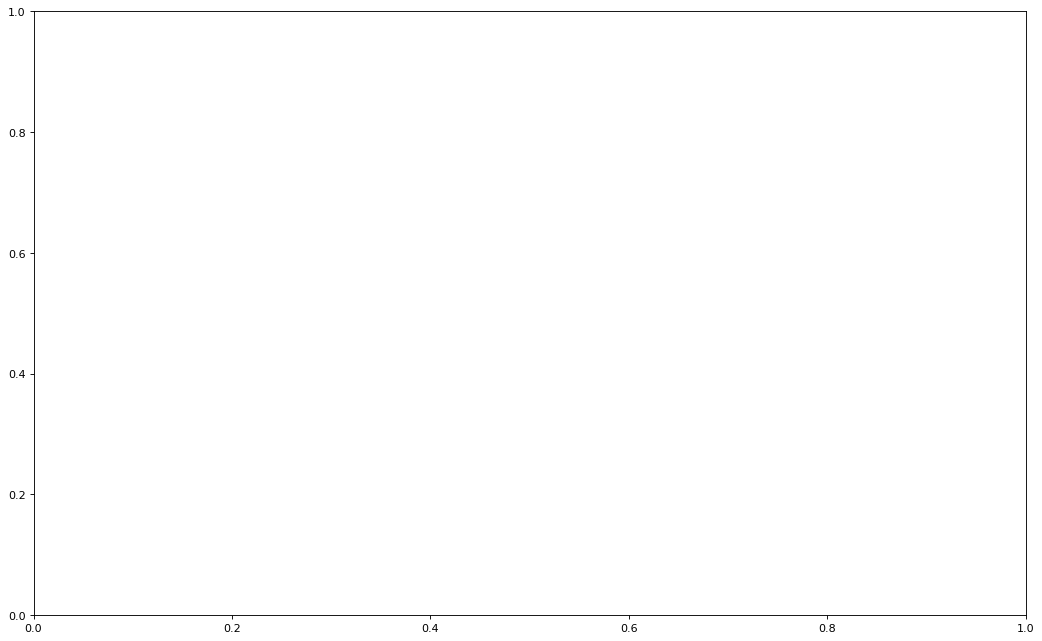

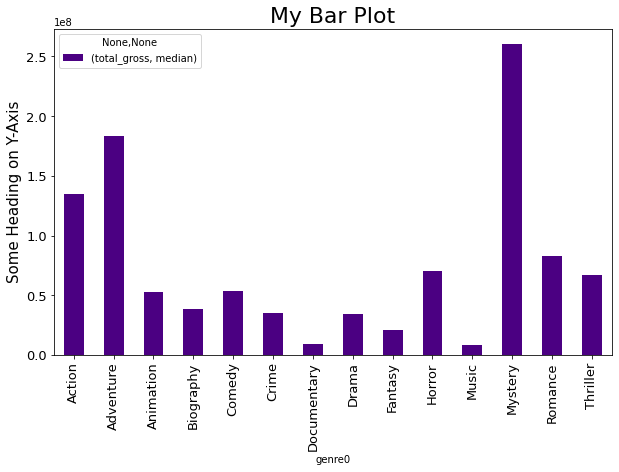

In [226]:
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Standard data manipulation packages
import pandas as pd
import numpy as np

fig, ax = plt.subplots(figsize=(16, 10), dpi=80)  
#make a dictioneray of the genres
generes = list(df['genre0'].unique())
genre_vs_gross = clean_df[['total_gross','genre0']].groupby(['genre0']).agg(['median'])


ax = genre_vs_gross.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=13, stacked=True);
ax.set_alpha(0.8)
ax.set_title("My Bar Plot", fontsize=22)
ax.set_ylabel("Some Heading on Y-Axis", fontsize=15);
plt.show()

In [ ]:
# visualization packages
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Standard data manipulation packages
import pandas as pd
import numpy as np

matplotlib_axes_logger.setLevel('ERROR')

# Set specific parameters for the visualizations
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

def genere_vs_gross():
    """
    This is a sample visualization function to show what one looks like.
    The code is borrowed from https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

    This function takes no arguments and shows a nice visualization without having all your code in the notebook itself.
    """

    # Set size of figure
    fig = plt.figure(figsize=(16, 10), dpi=80)  

    genre = df.

    # Import dataset 
    midwest = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/midwest_filter.csv")

    # Prepare Data 
    # Create as many colors as there are unique midwest['category']
    categories = np.unique(midwest['category'])
    colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

    # create ax element
    fig, ax = plt.subplots(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

    # Draw Plot for Each Category
    for i, category in enumerate(categories):
        plt.scatter('area', 'poptotal', 
                    data=midwest.loc[midwest.category==category, :], 
                    s=20, c=colors[i], label=str(category))

    # Decorations
    plt.gca().set(xlim=(0.0, 0.1), ylim=(0, 90000),
                  xlabel='Area', ylabel='Population')

    plt.xticks(fontsize=12); plt.yticks(fontsize=12)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.title("Scatterplot of Midwest Area vs Population", fontsize=22)
    plt.legend(fontsize=12)
    plt.savefig('./images/viz1.png', transparent = True)
    
    plt.show()  
    
    pass
